 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

# Introduction

The LMU site is located near Munich blah blah blah

# Data preparation

First, it is important to define the `**state mask**`, which basically is a raster that encodes the locations where the land surface parameters will be inferred. In this case, we have a Shapefile with the fields where data of interest have been collected over the LMU field campaign, and we will limit the inference to these fields only. The file in in [`data/ESU.shp`](data/ESU.shp), so we can just rasterise it into a 10m grid with the following extent

Extent in current projection: (697361.573352, 5347596.516110) - (703248.269722, 5354394.970670)
Rounded off for 10m grid 697100 5347200 703600 5354600

We can achieve that with the `gdal_rasterize` command:

    gdal_rasterize -of GTiff -burn 1 -te 697100 5347200 703600 5354600 -tr 10 10 -ot Byte \
                   -co "COMPRESS=DEFLATE" -l MNI_2017 MNI_2017.shp ESU.tif



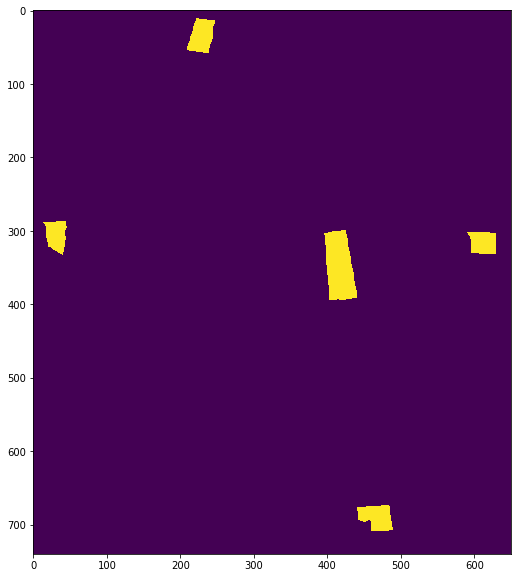

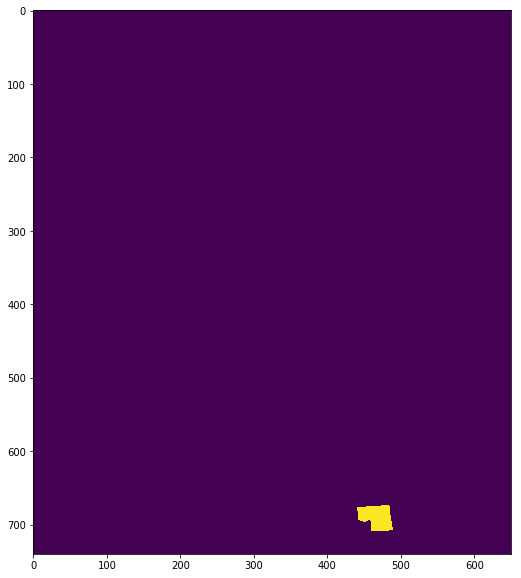

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gdal
import kafka
import os

sar_data_dir = "/media/nas_data/Thomas/S1/processed/MNI_2017/step3"
sar_data_dir = "/media/nas_data/Thomas/S1/step3"

g = gdal.Open("/media/tweiss/Daten/multiply/ESU.tif")
state_mask = g.ReadAsArray().astype(np.bool)
state_mask_2 = g.ReadAsArray().astype(np.bool)
#state_mask_2[0:500] = False

for i in (np.arange(0,len(state_mask),1)):
    #state_mask_2[i][0:350] = False
    #state_mask_2[i][500:] = False
    state_mask_2[0:600] = False

plt.figure(figsize=(10, 10))
plt.imshow(state_mask, interpolation="nearest")
plt.figure(figsize=(10, 10))
plt.imshow(state_mask_2, interpolation="nearest")

In [10]:
import osr
def reproject_image(source_img, target_img, dstSRSs=None):
    """Reprojects/Warps an image to fit exactly another image.
    Additionally, you can set the destination SRS if you want
    to or if it isn't defined in the source image."""
    g = gdal.Open(target_img)
    geo_t = g.GetGeoTransform()
    x_size, y_size = g.RasterXSize, g.RasterYSize
    xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
    xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
    ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
    ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
    xRes, yRes = abs(geo_t[1]), abs(geo_t[5])
    if dstSRSs is None:
        dstSRS = osr.SpatialReference()
        raster_wkt = g.GetProjection()
        dstSRS.ImportFromWkt(raster_wkt)
    else:
        dstSRS = dstSRSs
    g = gdal.Warp('', source_img, format='MEM',
                  outputBounds=[xmin, ymin, xmax, ymax], xRes=xRes, yRes=yRes,
                  dstSRS=dstSRS)
    return g

/media/nas_data/Thomas/S1/step3/S1A_IW_SLC__1SDV_20170314T165852_20170314T165919_015691_019D20_61E8_GC_RC_No_Su_Co_speckle.nc
NETCDF:"/media/nas_data/Thomas/S1/step3/S1A_IW_SLC__1SDV_20170314T165852_20170314T165919_015691_019D20_61E8_GC_RC_No_Su_Co_speckle.nc":sigma0_vh_single


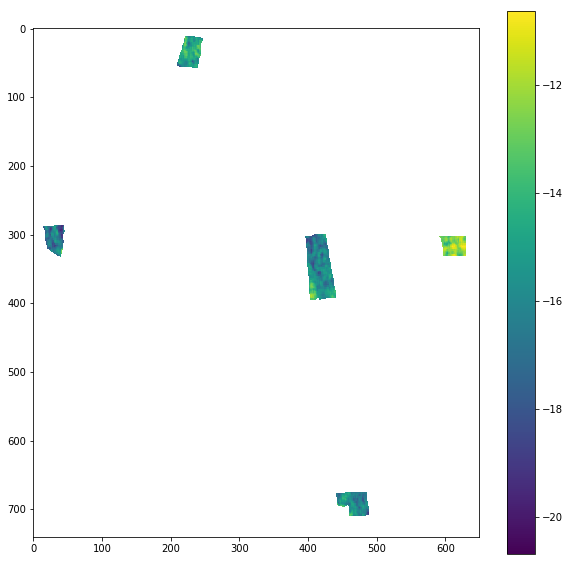

In [15]:
fname = "S1A_IW_SLC__1SDV_20170314T165852_20170314T165919_015691_019D20_61E8_GC_RC_No_Su_Co_speckle.nc"
fname = os.path.join(sar_data_dir, fname)
print(fname)
obs_file = 'NETCDF:"{:s}":sigma0_vh_single'.format(fname)
print(obs_file)
sigma_vh = reproject_image(obs_file, "/media/tweiss/Daten/multiply/ESU.tif").ReadAsArray()
obs_mask = sigma_vh < -900
sigma_vh[obs_mask] = np.nan
sigma_vh[~state_mask] = np.nan
plt.figure(figsize=(10,10))
plt.imshow(10*np.log10(sigma_vh), interpolation="nearest")
plt.colorbar()

(1122, 1682)


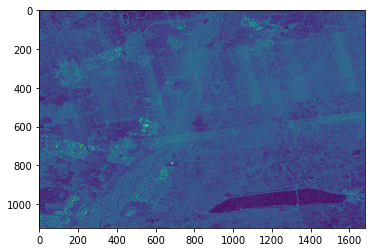

In [16]:
g = gdal.Open(obs_file)
data = g.ReadAsArray()
plt.imshow(10*np.log10(data))
print(data.shape)

In [18]:
sentinel1_observations = kafka.Sentinel1_Observations.S1Observations(
    sar_data_dir, "/media/tweiss/Daten/multiply/ESU.tif", emulators={
        'VH': kafka.observation_operators.sar_observation_operator, 
        'VV': kafka.observation_operators.sar_observation_operator})

#sentinel1_observations = kafka.Sentinel1_Observations.S1Observations("",
#    "data/ESU.tif", emulators={
#        'VH': kafka.observation_operators.sar_observation_operator, 
#        'VV': kafka.observation_operators.sar_observation_operator})




In [19]:
for tim in sentinel1_observations.dates:
    print(tim)
    data = sentinel1_observations.get_band_data(tim, 0)
    plt.figure(figsize=(10,10))
    observations = data.observations*1.
    observations[data.mask] = np.nan
    observations[~state_mask] = np.nan
    sigma_vv = observations
    data = sentinel1_observations.get_band_data(tim, 1)
    plt.figure(figsize=(10,10))
    observations = data.observations*1.
    observations[~data.mask] = np.nan
    observations[~state_mask] = np.nan
    sigma_vh = observations
    
    plt.imshow(10.*np.log(sigma_vh), interpolation="nearest")
    plt.colorbar()
    plt.title(tim)

2017-01-01 16:58:53


SystemError: error return without exception set

In [14]:
sentinel1_observations.dates

[datetime.datetime(2017, 3, 2, 16, 58, 52),
 datetime.datetime(2017, 3, 6, 5, 18, 4),
 datetime.datetime(2017, 3, 7, 17, 7, 4),
 datetime.datetime(2017, 3, 11, 5, 26, 13),
 datetime.datetime(2017, 3, 14, 16, 58, 52),
 datetime.datetime(2017, 3, 18, 5, 18, 4),
 datetime.datetime(2017, 3, 19, 17, 7, 4),
 datetime.datetime(2017, 3, 23, 5, 26, 13),
 datetime.datetime(2017, 3, 26, 16, 58, 53),
 datetime.datetime(2017, 3, 30, 5, 18, 4),
 datetime.datetime(2017, 3, 31, 17, 7, 4),
 datetime.datetime(2017, 4, 4, 5, 26, 13),
 datetime.datetime(2017, 4, 7, 16, 58, 53),
 datetime.datetime(2017, 4, 11, 5, 18, 5),
 datetime.datetime(2017, 4, 12, 17, 7, 5),
 datetime.datetime(2017, 4, 16, 5, 26, 14),
 datetime.datetime(2017, 4, 19, 16, 58, 54),
 datetime.datetime(2017, 4, 23, 5, 18, 5),
 datetime.datetime(2017, 4, 24, 17, 7, 5),
 datetime.datetime(2017, 4, 28, 5, 26, 14),
 datetime.datetime(2017, 5, 1, 16, 58, 54),
 datetime.datetime(2017, 5, 5, 5, 18, 6),
 datetime.datetime(2017, 5, 6, 17, 7, 6),
 d

In [14]:
kalman_filter = kafka.LinearKalman(sentinel1_observations, None, state_mask, 
                                   kafka.observation_operators.create_sar_observation_operator,
                                   linear=False, diagnostics=True, parameters_list='LAI')

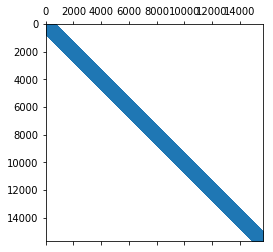

In [19]:
import scipy.sparse as sp
mean_lai0 = np.zeros((740, 650))
mean_sm0 = np.zeros((740, 650))
std_lai0 = np.zeros((740, 650))
std_sm0 = np.zeros((740, 650))

mean_lai0[state_mask] = 2
mean_sm0[state_mask] = 0.1
std_lai0[state_mask] = 2.
std_sm0[state_mask] = 0.2


x_prior = np.c_[mean_lai0[state_mask], mean_sm0[state_mask]].flatten()
sigma_prior = np.c_[std_lai0[state_mask], std_sm0[state_mask]].flatten()
sigma_prior_inv = 1./(sigma_prior**2)
N = sigma_prior_inv.shape[0]
P_inv = sp.lil_matrix((N, N))
P_inv.setdiag(sigma_prior_inv)
plt.spy(P_inv)

In [20]:
import datetime
time_grid = [datetime.datetime(2017, 3, 14),
             datetime.datetime(2017, 3, 15),
             datetime.datetime(2017, 3, 16),
             datetime.datetime(2017, 3, 17)
            ]

In [21]:
aaa= kalman_filter.run(time_grid, x_prior, None, P_inv)

AttributeError: 'NoneType' object has no attribute 'dump_data'

In [ ]:
%debug

> /home/tweiss/anaconda3_new/lib/python3.6/site-packages/KaFKA-0.0.0-py3.6.egg/kafka/linear_kf.py(204)run()
    202                                      is_robust=is_robust, diag_str=diag_str)
    203             LOG.info("Dumping results to disk")
--> 204             self.output.dump_data(timestep, x_analysis, P_analysis,
    205                                   P_analysis_inverse, self.state_mask, self.n_params)
    206 



In [12]:
aaa

In [23]:
print(np.arange(0,len(state_mask),1))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [22]:
help(np.arange)

Help on built-in function arange in module numpy.core.multiarray:

arange(...)
    arange([start,] stop[, step,], dtype=None)
    
    Return evenly spaced values within a given interval.
    
    Values are generated within the half-open interval ``[start, stop)``
    (in other words, the interval including `start` but excluding `stop`).
    For integer arguments the function is equivalent to the Python built-in
    `range <http://docs.python.org/lib/built-in-funcs.html>`_ function,
    but returns an ndarray rather than a list.
    
    When using a non-integer step, such as 0.1, the results will often not
    be consistent.  It is better to use ``linspace`` for these cases.
    
    Parameters
    ----------
    start : number, optional
        Start of interval.  The interval includes this value.  The default
        start value is 0.
    stop : number
        End of interval.  The interval does not include this value, except
        in some cases where `step` is not an integer and